In [1]:
import re
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_initial = pd.read_csv('files_for_lab/customer_churn.csv')

In [3]:
df_initial.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
class CustomInitialDataCleaner:
    def __init__(self, drop_features=[]):
        self.drop_features = drop_features
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __drop_features(self, X):
        return X.drop(self.drop_features, axis=1, inplace=False)
    
    def __camel_to_snake(self, name):
        name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    
    def __standardize_feature_headers(self, X):
        X.columns = [self.__camel_to_snake(col) for col in X.columns]
        return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        X = self.__drop_features(X)
        return self.__standardize_feature_headers(X)

In [5]:
custom_cleaner = CustomInitialDataCleaner(drop_features=['customerID'])
df = custom_cleaner.clean(df_initial)
df.head(3)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## EDA

In [6]:
df.select_dtypes('number').apply(lambda col: col.unique())

senior_citizen                                                [0, 1]
tenure             [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
monthly_charges    [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...
dtype: object

In [7]:
df.select_dtypes('object').apply(lambda col: col.unique())

gender                                                  [Female, Male]
partner                                                      [Yes, No]
dependents                                                   [No, Yes]
phone_service                                                [No, Yes]
multiple_lines                             [No phone service, No, Yes]
internet_service                                [DSL, Fiber optic, No]
online_security                         [No, Yes, No internet service]
online_backup                           [Yes, No, No internet service]
device_protection                       [No, Yes, No internet service]
tech_support                            [No, Yes, No internet service]
streaming_tv                            [No, Yes, No internet service]
streaming_movies                        [No, Yes, No internet service]
contract                          [Month-to-month, One year, Two year]
paperless_billing                                            [Yes, No]
paymen

In [8]:
df['churn'].value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [9]:
# show percentages
df['churn'].value_counts() / df.shape[0]

No     0.73463
Yes    0.26537
Name: churn, dtype: float64

In [10]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

## Data Preprocessing

- Logistic Regression will only be done on variables tenure, senior_citizen and monthly_charges
- tagret variable is churn

In [11]:
# exract only the relevant features + target from dataset
df_final = df[['tenure', 'senior_citizen', 'monthly_charges', 'churn']]

In [12]:
X = df_final.drop('churn', axis=1, inplace=False)
y = df_final['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
def make_custom_pipeline_with_sampler(sampler):
    p = Pipeline([
        ('scaling', MinMaxScaler()),
        ('sampling', sampler),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ])
    return p
    
def make_custom_pipeline_no_sampler():
    p = Pipeline([
        ('scaling', MinMaxScaler()),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ])
    return p

### Evaluate Models

In [14]:
# utility function to add model results to dataframe of overall overview
def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler) if sampler else None,
                                          scores_test.at["accuracy","f1-score"], scores_test.at["Yes","f1-score"],
                                          scores_test.at["Yes","precision"], scores_test.at["Yes","recall"],
                                          scores_test.at["No","f1-score"], scores_test.at["No","precision"],
                                          scores_test.at["No","recall"]]

model_comparisson = pd.DataFrame([], columns=['model', 'sampler', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])

def get_class_name(cl):
    return cl.__class__.__name__

def show_confusion_matrix(y_pred, y_test, classes, title):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)
    plt.show()

LogisticRegression - no sampler
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.63      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



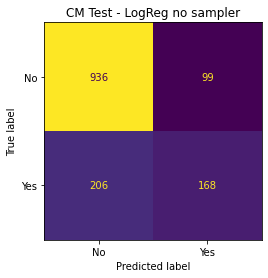

In [15]:
# MinMax scaler with LogisticRegression - no sampler
log_reg = make_custom_pipeline_no_sampler()
log_reg.fit(X_train, y_train)
# predict
log_reg_y_pred = log_reg.predict(X_test)
print('LogisticRegression - no sampler')
print(classification_report(y_test, log_reg_y_pred))
scores_test_logreg = pd.DataFrame(classification_report(y_test, log_reg_y_pred, output_dict=True)).T
add_scores_to_overall_results(model_comparisson, scores_test_logreg, None, log_reg[1])
show_confusion_matrix(log_reg_y_pred, y_test, log_reg[1].classes_, 'CM Test - LogReg no sampler')

LogisticRegression - SMOTE
              precision    recall  f1-score   support

          No       0.89      0.71      0.79      1035
         Yes       0.49      0.76      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.78      0.73      0.74      1409



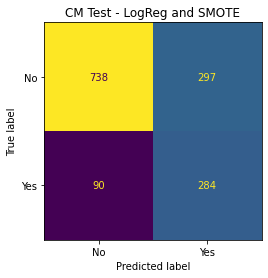

In [16]:
# MinMax scaler with LogisticRegression - sampler: SMOTE
log_reg_smote = make_custom_pipeline_with_sampler(SMOTE())
log_reg_smote.fit(X_train, y_train)

log_reg_smote_y_pred = log_reg_smote.predict(X_test)
print('LogisticRegression - SMOTE')
print(classification_report(y_test, log_reg_smote_y_pred))
scores_test_logregsmote = pd.DataFrame(classification_report(y_test, log_reg_smote_y_pred, output_dict=True)).T
add_scores_to_overall_results(model_comparisson, scores_test_logregsmote, log_reg_smote[1], log_reg_smote[2])
show_confusion_matrix(log_reg_smote_y_pred, y_test, log_reg_smote[2].classes_, 'CM Test - LogReg and SMOTE')

LogisticRegression - TOMEK
              precision    recall  f1-score   support

          No       0.84      0.87      0.85      1035
         Yes       0.59      0.54      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



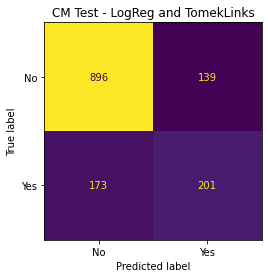

In [17]:
# MinMax scaler with LogisticRegression - sampler: TomekLinks
log_reg_tomek = make_custom_pipeline_with_sampler(TomekLinks())
log_reg_tomek.fit(X_train, y_train)

log_reg_tomek_y_pred = log_reg_tomek.predict(X_test)
print('LogisticRegression - TOMEK')
print(classification_report(y_test, log_reg_tomek_y_pred))

scores_test_logregtomek = pd.DataFrame(classification_report(y_test, log_reg_tomek_y_pred, output_dict=True)).T
add_scores_to_overall_results(model_comparisson, scores_test_logregtomek, log_reg_tomek[1], log_reg_tomek[2])
show_confusion_matrix(log_reg_tomek_y_pred, y_test, log_reg_tomek[2].classes_, 'CM Test - LogReg and TomekLinks')

### Models in comparisson

In [18]:
model_comparisson

,model,sampler,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,None,0.783534,0.524181,0.629213,0.449198,0.859899,0.819615,0.904348
1,LogisticRegression,SMOTE,0.725337,0.594764,0.488812,0.759358,0.792271,0.891304,0.713043
2,LogisticRegression,TomekLinks,0.778566,0.563025,0.591176,0.537433,0.851711,0.838167,0.865700


Logistic Regression no sampler:
- results from fitting the model on unbalanced data set gives us still a quite good f1 score since it probably  uses the class proportions of 27% vs 73% in dataset during fitting
- we see however that recall for the minory class 'Yes' is 0.45 which would indicate that the model does not recognize nearly 50% of the 'Yes' cases correctly

Logistic Regression with SMOTE:
- Here the f1 score is a little lower compared to the first model, but we see that recall has improved significantly for the positive class (minority class). However, the precision for minority class dropped

Logistic Regression with Tomek Links:
- Here the f1 score is the second best for the three models, also notable is that the minor class recall and precision are much more balanced in comparisson to the other two models. 

It is important to point out that depending on my use case I would decide on which model to use. Just considering the overall f1 score is not enough. If e.g. I need to make sure that all my positive cases are correctly predicted I would go for the second model (from this selection) since here the recall for positive class it the highest. If I need a more balanced approach where precision is above 50% and recall is above 50% I would chose the third model (again, just judging based on this selection of models).   
